In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)


<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

look_backs = [60, 75, 90, 120]
    
def objective(trial):
    hp = {
        # ── Data & Windowing ────────────────────────────────────────────────
        "look_back":        trial.suggest_categorical("look_back", look_backs),

        # ── Architecture ───────────────────────────────────────────────────
        "SHORT_UNITS":      trial.suggest_categorical("SHORT_UNITS",[64, 96, 128]),    
        "LONG_UNITS":       trial.suggest_categorical("LONG_UNITS", [128, 192, 256]),  
        "DROPOUT_SHORT":    trial.suggest_float("DROPOUT_SHORT",   0.10, 0.40),          
        "DROPOUT_LONG":     trial.suggest_float("DROPOUT_LONG",    0.20, 0.50),          
        "ATT_HEADS":        trial.suggest_categorical("ATT_HEADS", [8,    16]),      
        "ATT_DROPOUT":      trial.suggest_float("ATT_DROPOUT",      0.10, 0.40),          
        "CONV_K":           trial.suggest_int("CONV_K",             2,    5),            
        "CONV_DILATION":    trial.suggest_int("CONV_DILATION",      1,    2),              
        "SMOOTH_K":         trial.suggest_int("SMOOTH_K",           3,    7),    
        "SMOOTH_DILATION":  trial.suggest_int("SMOOTH_DILATION",    1,    2),             

        # ── Optimizer & Scheduler ─────────────────────────────────────────
        "INITIAL_LR":       trial.suggest_float("INITIAL_LR",    2e-5,  4e-4,  log=True), 
        "ETA_MIN":          trial.suggest_float("ETA_MIN",       1e-7,  1e-5,  log=True),  
        "WEIGHT_DECAY":     trial.suggest_float("WEIGHT_DECAY",  1e-4,  1e-2,  log=True),  
        "CLIPNORM":         trial.suggest_float("CLIPNORM",      0.5,   5.0),          

        # ── Loss & Smoothing Weights ──────────────────────────────────────
        "CLS_LOSS_WEIGHT":  trial.suggest_float("CLS_LOSS_WEIGHT", 1e-2,   1e-1,  log=True), 
        "SMOOTH_ALPHA":     trial.suggest_float("SMOOTH_ALPHA",    1e-4,   1e-2,  log=True), 
        "SMOOTH_BETA":      trial.suggest_float("SMOOTH_BETA",     10.0,   30.0),         
        "SMOOTH_DELTA":     trial.suggest_float("SMOOTH_DELTA",    1e-3,   1e-2,  log=True),  
        "DIFF1_WEIGHT":     trial.suggest_float("DIFF1_WEIGHT",    0.5,    2.0),          
        "DIFF2_WEIGHT":     trial.suggest_float("DIFF2_WEIGHT",    0.0,    0.5),         
    }


    print(f"\n▶ Trial {trial.number} hyperparams:\n{hp}\n")

    # Compute session‐start adjusted for look_back
    hp_sess_start = dt.time(
        *divmod(
            (params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"],
            60
        )
    )

    # Build data loaders
    train_loader, val_loader, test_loader, _, _, _ = models_core.model_core_pipeline(
        df               = df_feat_sel,
        look_back        = hp["look_back"],
        sess_start       = hp_sess_start,
        train_prop       = params.train_prop,
        val_prop         = params.val_prop,
        train_batch      = params.hparams["TRAIN_BATCH"],
        num_workers      = params.hparams["NUM_WORKERS"],
        prefetch_factor  = params.hparams["TRAIN_PREFETCH_FACTOR"],
        signal_thresh    = params.best_optuna_params["buy_threshold"],
        return_thresh    = params.return_thresh_tick
    )

    # Instantiate model with tunable architecture and smoothing
    model = params.model_selected.ModelClass(
        n_feats         = len(params.features_cols_tick),
        short_units     = hp["SHORT_UNITS"],
        long_units      = hp["LONG_UNITS"],
        dropout_short   = hp["DROPOUT_SHORT"],
        dropout_long    = hp["DROPOUT_LONG"],
        att_heads       = hp["ATT_HEADS"],
        att_drop        = hp["ATT_DROPOUT"],
        conv_k          = hp["CONV_K"],
        conv_dilation   = hp["CONV_DILATION"],
        smooth_k        = hp["SMOOTH_K"],
        smooth_dilation = hp["SMOOTH_DILATION"]
    ).to(params.device)

    # Build optimizer, schedulers, scaler
    optimizer, plateau_sched, _, scaler, _clipnorm = \
        models_core.make_optimizer_and_scheduler(
            model        = model,
            initial_lr   = hp["INITIAL_LR"],
            weight_decay = hp["WEIGHT_DECAY"],
            clipnorm     = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer,
        T_0    = params.hparams['T_0'],
        T_mult = params.hparams['T_MULT'],
        eta_min= hp['ETA_MIN']
    )

    # Run the custom training loop with direct loss‐weight args
    best_val_rmse = params.model_selected.model_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device,

        # Tunable loss & smoothing weights
        cls_loss_weight     = hp["CLS_LOSS_WEIGHT"],
        smooth_alpha        = hp["SMOOTH_ALPHA"],
        smooth_beta         = hp["SMOOTH_BETA"],
        smooth_delta        = hp["SMOOTH_DELTA"],
        diff1_weight        = hp["DIFF1_WEIGHT"],
        diff2_weight        = hp["DIFF2_WEIGHT"],
    )

    # Clean up
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del train_loader, val_loader, test_loader
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return best_val_rmse


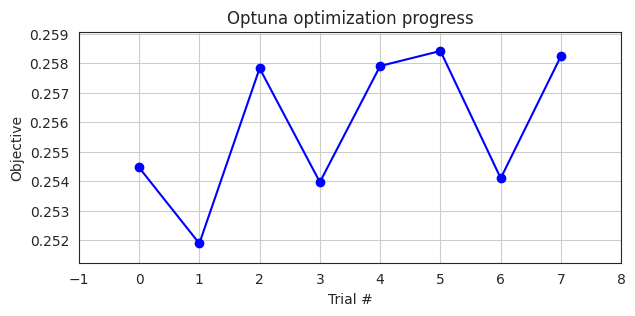

In [7]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-10-01 23:03:41,347] A new study created in RDB with name: no-name-35a7f6ba-34ca-40a7-ba69-4d83826ed934



▶ Trial 0 hyperparams:
{'look_back': 60, 'SHORT_UNITS': 128, 'LONG_UNITS': 256, 'DROPOUT_SHORT': 0.1279408622977021, 'DROPOUT_LONG': 0.31008797037696095, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.14838217997498224, 'CONV_K': 2, 'CONV_DILATION': 1, 'SMOOTH_K': 7, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 5.935055977776563e-05, 'ETA_MIN': 1.6486386767402343e-06, 'WEIGHT_DECAY': 0.0015601252162721195, 'CLIPNORM': 4.504870842573761, 'CLS_LOSS_WEIGHT': 0.0595077254758468, 'SMOOTH_ALPHA': 0.0003977224635884634, 'SMOOTH_BETA': 21.487678277113872, 'SMOOTH_DELTA': 0.0023036135649961366, 'DIFF1_WEIGHT': 0.9428417523650069, 'DIFF2_WEIGHT': 0.3172622911294801}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

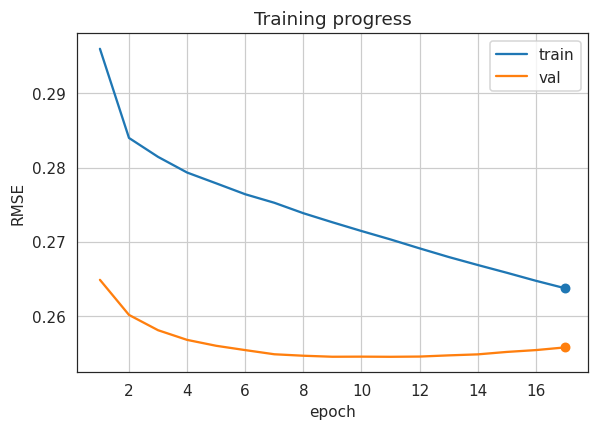

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.29603 MAE=0.24138 R2=-0.03866 | Acc=0.70019 Prec=0.33806 Rec=0.08744 F1=0.13894 AUROC=0.56932 | T_ACC=0.34913 T_P=0.35163 T_R=0.34913 T_F1=0.16283 T_AUC=0.54708
VALID→ RMSE=0.26486 MAE=0.19947 R2=0.14843 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.69783 | T_ACC=0.41773 T_P=0.33350 T_R=0.41773 T_F1=0.07660 T_AUC=0.67596


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.28400 MAE=0.23304 R2=0.04405 | Acc=0.69598 Prec=0.37462 Rec=0.14788 F1=0.21205 AUROC=0.57003 | T_ACC=0.34787 T_P=0.34969 T_R=0.34787 T_F1=0.17390 T_AUC=0.54474
VALID→ RMSE=0.26012 MAE=0.19850 R2=0.17862 | Acc=0.71511 Prec=0.83320 Rec=0.01047 F1=0.02068 AUROC=0.72518 | T_ACC=0.43801 T_P=0.33352 T_R=0.43801 T_F1=0.07894 T_AUC=0.68402


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.28145 MAE=0.23092 R2=0.06117 | Acc=0.71264 Prec=0.44688 Rec=0.16302 F1=0.23890 AUROC=0.59779 | T_ACC=0.34999 T_P=0.35012 T_R=0.34999 T_F1=0.17876 T_AUC=0.54622
VALID→ RMSE=0.25806 MAE=0.19800 R2=0.19159 | Acc=0.72785 Prec=0.79683 Rec=0.07078 F1=0.13000 AUROC=0.73347 | T_ACC=0.44190 T_P=0.33354 T_R=0.44190 T_F1=0.08496 T_AUC=0.68774


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.27933 MAE=0.22944 R2=0.07522 | Acc=0.72266 Prec=0.49654 Rec=0.18191 F1=0.26627 AUROC=0.61951 | T_ACC=0.35067 T_P=0.35009 T_R=0.35067 T_F1=0.18372 T_AUC=0.54686
VALID→ RMSE=0.25675 MAE=0.19758 R2=0.19975 | Acc=0.73665 Prec=0.76718 Rec=0.11967 F1=0.20705 AUROC=0.73730 | T_ACC=0.44691 T_P=0.33353 T_R=0.44691 T_F1=0.09012 T_AUC=0.69047


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.27788 MAE=0.22831 R2=0.08483 | Acc=0.72925 Prec=0.52743 Rec=0.20442 F1=0.29464 AUROC=0.63658 | T_ACC=0.35265 T_P=0.35058 T_R=0.35265 T_F1=0.18727 T_AUC=0.54906
VALID→ RMSE=0.25596 MAE=0.19716 R2=0.20470 | Acc=0.74152 Prec=0.74836 Rec=0.15113 F1=0.25147 AUROC=0.73966 | T_ACC=0.43876 T_P=0.33355 T_R=0.43876 T_F1=0.09262 T_AUC=0.69346


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.27640 MAE=0.22716 R2=0.09451 | Acc=0.73409 Prec=0.54800 Rec=0.22121 F1=0.31519 AUROC=0.64930 | T_ACC=0.35365 T_P=0.35119 T_R=0.35365 T_F1=0.18858 T_AUC=0.55019
VALID→ RMSE=0.25537 MAE=0.19691 R2=0.20832 | Acc=0.74461 Prec=0.73743 Rec=0.17245 F1=0.27953 AUROC=0.74133 | T_ACC=0.43223 T_P=0.33354 T_R=0.43223 T_F1=0.09510 T_AUC=0.69520


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.27525 MAE=0.22635 R2=0.10203 | Acc=0.73804 Prec=0.56317 Rec=0.23646 F1=0.33307 AUROC=0.66056 | T_ACC=0.35298 T_P=0.35158 T_R=0.35298 T_F1=0.18916 T_AUC=0.55150
VALID→ RMSE=0.25481 MAE=0.19743 R2=0.21180 | Acc=0.74653 Prec=0.73121 Rec=0.18619 F1=0.29681 AUROC=0.74274 | T_ACC=0.43247 T_P=0.33356 T_R=0.43247 T_F1=0.09549 T_AUC=0.69727


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.27384 MAE=0.22541 R2=0.11120 | Acc=0.74063 Prec=0.57158 Rec=0.24917 F1=0.34705 AUROC=0.67014 | T_ACC=0.35363 T_P=0.35252 T_R=0.35363 T_F1=0.19013 T_AUC=0.55382
VALID→ RMSE=0.25461 MAE=0.19778 R2=0.21302 | Acc=0.74789 Prec=0.72711 Rec=0.19608 F1=0.30887 AUROC=0.74404 | T_ACC=0.43180 T_P=0.33357 T_R=0.43180 T_F1=0.09452 T_AUC=0.69989


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.27262 MAE=0.22455 R2=0.11912 | Acc=0.74369 Prec=0.58192 Rec=0.26091 F1=0.36028 AUROC=0.67977 | T_ACC=0.35371 T_P=0.35277 T_R=0.35371 T_F1=0.18927 T_AUC=0.55452
VALID→ RMSE=0.25448 MAE=0.19845 R2=0.21387 | Acc=0.74868 Prec=0.72313 Rec=0.20289 F1=0.31688 AUROC=0.74517 | T_ACC=0.44883 T_P=0.33359 T_R=0.44883 T_F1=0.09072 T_AUC=0.70326


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.27144 MAE=0.22373 R2=0.12674 | Acc=0.74584 Prec=0.58788 Rec=0.27172 F1=0.37166 AUROC=0.68854 | T_ACC=0.35375 T_P=0.35404 T_R=0.35375 T_F1=0.18886 T_AUC=0.55723
VALID→ RMSE=0.25449 MAE=0.19880 R2=0.21378 | Acc=0.74923 Prec=0.72035 Rec=0.20782 F1=0.32258 AUROC=0.74610 | T_ACC=0.45776 T_P=0.33360 T_R=0.45776 T_F1=0.08943 T_AUC=0.70846


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.27030 MAE=0.22283 R2=0.13403 | Acc=0.74793 Prec=0.59438 Rec=0.27963 F1=0.38033 AUROC=0.69683 | T_ACC=0.35528 T_P=0.35541 T_R=0.35528 T_F1=0.19077 T_AUC=0.56009
VALID→ RMSE=0.25447 MAE=0.19925 R2=0.21391 | Acc=0.74981 Prec=0.71803 Rec=0.21268 F1=0.32815 AUROC=0.74687 | T_ACC=0.47721 T_P=0.33362 T_R=0.47721 T_F1=0.08925 T_AUC=0.71509


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.26910 MAE=0.22188 R2=0.14173 | Acc=0.74978 Prec=0.59959 Rec=0.28741 F1=0.38857 AUROC=0.70445 | T_ACC=0.35684 T_P=0.35610 T_R=0.35684 T_F1=0.19250 T_AUC=0.56314
VALID→ RMSE=0.25450 MAE=0.19961 R2=0.21372 | Acc=0.75027 Prec=0.71549 Rec=0.21706 F1=0.33308 AUROC=0.74743 | T_ACC=0.46658 T_P=0.33364 T_R=0.46658 T_F1=0.08803 T_AUC=0.72151


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.26794 MAE=0.22088 R2=0.14914 | Acc=0.75156 Prec=0.60473 Rec=0.29423 F1=0.39586 AUROC=0.71158 | T_ACC=0.35721 T_P=0.35743 T_R=0.35721 T_F1=0.19391 T_AUC=0.56522
VALID→ RMSE=0.25466 MAE=0.20021 R2=0.21272 | Acc=0.75033 Prec=0.71221 Rec=0.21979 F1=0.33591 AUROC=0.74776 | T_ACC=0.45752 T_P=0.33363 T_R=0.45752 T_F1=0.08673 T_AUC=0.72838


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.26686 MAE=0.22000 R2=0.15598 | Acc=0.75285 Prec=0.60783 Rec=0.30044 F1=0.40212 AUROC=0.71712 | T_ACC=0.35760 T_P=0.35818 T_R=0.35760 T_F1=0.19487 T_AUC=0.56747
VALID→ RMSE=0.25480 MAE=0.20062 R2=0.21188 | Acc=0.75013 Prec=0.70577 Rec=0.22340 F1=0.33938 AUROC=0.74793 | T_ACC=0.45743 T_P=0.33362 T_R=0.45743 T_F1=0.08537 T_AUC=0.73520


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.26581 MAE=0.21914 R2=0.16259 | Acc=0.75421 Prec=0.61152 Rec=0.30570 F1=0.40763 AUROC=0.72292 | T_ACC=0.35799 T_P=0.35884 T_R=0.35799 T_F1=0.19495 T_AUC=0.56932
VALID→ RMSE=0.25513 MAE=0.20144 R2=0.20985 | Acc=0.75009 Prec=0.70070 Rec=0.22717 F1=0.34310 AUROC=0.74793 | T_ACC=0.45562 T_P=0.33363 T_R=0.45562 T_F1=0.08262 T_AUC=0.74115


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.26473 MAE=0.21824 R2=0.16940 | Acc=0.75545 Prec=0.61508 Rec=0.30996 F1=0.41220 AUROC=0.72807 | T_ACC=0.35816 T_P=0.35949 T_R=0.35816 T_F1=0.19506 T_AUC=0.57050
VALID→ RMSE=0.25537 MAE=0.20220 R2=0.20831 | Acc=0.75025 Prec=0.69646 Rec=0.23169 F1=0.34770 AUROC=0.74784 | T_ACC=0.42483 T_P=0.33361 T_R=0.42483 T_F1=0.07923 T_AUC=0.74626


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.26372 MAE=0.21743 R2=0.17568 | Acc=0.75660 Prec=0.61847 Rec=0.31356 F1=0.41614 AUROC=0.73284 | T_ACC=0.35884 T_P=0.36041 T_R=0.35884 T_F1=0.19475 T_AUC=0.57240
VALID→ RMSE=0.25574 MAE=0.20284 R2=0.20607 | Acc=0.75022 Prec=0.69134 Rec=0.23593 F1=0.35180 AUROC=0.74782 | T_ACC=0.40293 T_P=0.33359 T_R=0.40293 T_F1=0.07306 T_AUC=0.74965


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 18
✅ Final best model saved: AAPL_0.25447_fin.pth


[I 2025-10-01 23:28:45,606] Trial 0 finished with value: 0.25447016954421997 and parameters: {'look_back': 60, 'SHORT_UNITS': 128, 'LONG_UNITS': 256, 'DROPOUT_SHORT': 0.1279408622977021, 'DROPOUT_LONG': 0.31008797037696095, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.14838217997498224, 'CONV_K': 2, 'CONV_DILATION': 1, 'SMOOTH_K': 7, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 5.935055977776563e-05, 'ETA_MIN': 1.6486386767402343e-06, 'WEIGHT_DECAY': 0.0015601252162721195, 'CLIPNORM': 4.504870842573761, 'CLS_LOSS_WEIGHT': 0.0595077254758468, 'SMOOTH_ALPHA': 0.0003977224635884634, 'SMOOTH_BETA': 21.487678277113872, 'SMOOTH_DELTA': 0.0023036135649961366, 'DIFF1_WEIGHT': 0.9428417523650069, 'DIFF2_WEIGHT': 0.3172622911294801}. Best is trial 0 with value: 0.25447016954421997.



▶ Trial 1 hyperparams:
{'look_back': 60, 'SHORT_UNITS': 128, 'LONG_UNITS': 192, 'DROPOUT_SHORT': 0.33455375684121375, 'DROPOUT_LONG': 0.29533218051627624, 'ATT_HEADS': 16, 'ATT_DROPOUT': 0.2670455546180787, 'CONV_K': 5, 'CONV_DILATION': 1, 'SMOOTH_K': 7, 'SMOOTH_DILATION': 2, 'INITIAL_LR': 0.00010821291019653682, 'ETA_MIN': 5.192135457828995e-06, 'WEIGHT_DECAY': 0.004137491592481016, 'CLIPNORM': 2.198679831891365, 'CLS_LOSS_WEIGHT': 0.028260087124623683, 'SMOOTH_ALPHA': 0.0009866684467343101, 'SMOOTH_BETA': 13.796749905503374, 'SMOOTH_DELTA': 0.002784339567458579, 'DIFF1_WEIGHT': 1.5100592432381235, 'DIFF2_WEIGHT': 0.15007129089173604}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

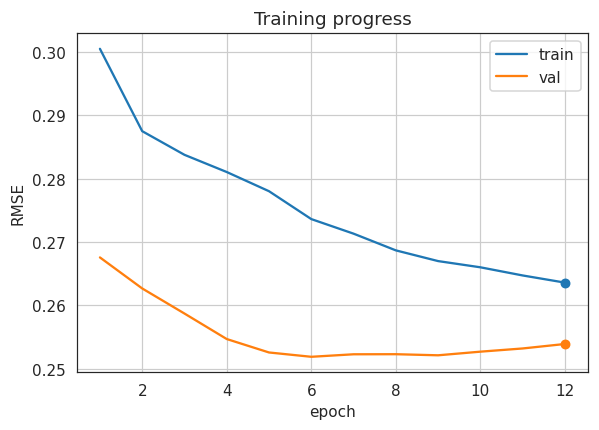

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.30052 MAE=0.25226 R2=-0.07037 | Acc=0.68840 Prec=0.31824 Rec=0.11064 F1=0.16419 AUROC=0.55802 | T_ACC=0.32183 T_P=0.32186 T_R=0.32183 T_F1=0.18245 T_AUC=0.47667
VALID→ RMSE=0.26758 MAE=0.19614 R2=0.13081 | Acc=0.71272 Prec=1.00000 Rec=0.00007 F1=0.00014 AUROC=0.70051 | T_ACC=0.20993 T_P=0.33293 T_R=0.20993 T_F1=0.03909 T_AUC=0.29556


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.28751 MAE=0.23914 R2=0.02026 | Acc=0.70182 Prec=0.40538 Rec=0.16683 F1=0.23638 AUROC=0.59893 | T_ACC=0.32221 T_P=0.31964 T_R=0.32221 T_F1=0.16070 T_AUC=0.47408
VALID→ RMSE=0.26268 MAE=0.19528 R2=0.16234 | Acc=0.72203 Prec=0.89653 Rec=0.03669 F1=0.07049 AUROC=0.73731 | T_ACC=0.20862 T_P=0.33287 T_R=0.20862 T_F1=0.03676 T_AUC=0.26732


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.28378 MAE=0.23670 R2=0.04554 | Acc=0.71984 Prec=0.48440 Rec=0.19784 F1=0.28094 AUROC=0.63658 | T_ACC=0.32045 T_P=0.31653 T_R=0.32045 T_F1=0.14981 T_AUC=0.46972
VALID→ RMSE=0.25872 MAE=0.19560 R2=0.18741 | Acc=0.73760 Prec=0.78463 Rec=0.11944 F1=0.20731 AUROC=0.74648 | T_ACC=0.21117 T_P=0.33292 T_R=0.21117 T_F1=0.04128 T_AUC=0.24041


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.28106 MAE=0.23508 R2=0.06372 | Acc=0.73479 Prec=0.54609 Rec=0.24463 F1=0.33790 AUROC=0.67394 | T_ACC=0.31923 T_P=0.31386 T_R=0.31923 T_F1=0.14093 T_AUC=0.46558
VALID→ RMSE=0.25470 MAE=0.19473 R2=0.21250 | Acc=0.74703 Prec=0.72082 Rec=0.19502 F1=0.30698 AUROC=0.74734 | T_ACC=0.20398 T_P=0.33294 T_R=0.20398 T_F1=0.04446 T_AUC=0.23092


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.25258_chp.pth
Epoch 005
TRAIN→ RMSE=0.27803 MAE=0.23299 R2=0.08381 | Acc=0.74516 Prec=0.58393 Rec=0.27404 F1=0.37303 AUROC=0.70069 | T_ACC=0.31919 T_P=0.31380 T_R=0.31919 T_F1=0.13402 T_AUC=0.46871
VALID→ RMSE=0.25258 MAE=0.19602 R2=0.22557 | Acc=0.75154 Prec=0.68306 Rec=0.25218 F1=0.36836 AUROC=0.74467 | T_ACC=0.18601 T_P=0.33291 T_R=0.18601 T_F1=0.04454 T_AUC=0.26911


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.25190_chp.pth
Epoch 006
TRAIN→ RMSE=0.27363 MAE=0.22934 R2=0.11257 | Acc=0.75051 Prec=0.60451 Rec=0.28378 F1=0.38625 AUROC=0.71852 | T_ACC=0.32206 T_P=0.31741 T_R=0.32206 T_F1=0.12972 T_AUC=0.47679
VALID→ RMSE=0.25190 MAE=0.19713 R2=0.22973 | Acc=0.75224 Prec=0.66430 Rec=0.27822 F1=0.39219 AUROC=0.74238 | T_ACC=0.15592 T_P=0.33281 T_R=0.15592 T_F1=0.03915 T_AUC=0.32597


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.27133 MAE=0.22761 R2=0.12743 | Acc=0.75366 Prec=0.61232 Rec=0.29853 F1=0.40137 AUROC=0.72833 | T_ACC=0.32510 T_P=0.32134 T_R=0.32510 T_F1=0.12491 T_AUC=0.48710
VALID→ RMSE=0.25229 MAE=0.20019 R2=0.22731 | Acc=0.75225 Prec=0.65364 Rec=0.29283 F1=0.40447 AUROC=0.74166 | T_ACC=0.18835 T_P=0.33539 T_R=0.18835 T_F1=0.03316 T_AUC=0.35726


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.26870 MAE=0.22506 R2=0.14431 | Acc=0.75512 Prec=0.61585 Rec=0.30506 F1=0.40801 AUROC=0.73463 | T_ACC=0.32883 T_P=0.32560 T_R=0.32883 T_F1=0.11920 T_AUC=0.49515
VALID→ RMSE=0.25230 MAE=0.20105 R2=0.22724 | Acc=0.75266 Prec=0.64780 Rec=0.30478 F1=0.41453 AUROC=0.74237 | T_ACC=0.20308 T_P=0.33402 T_R=0.20308 T_F1=0.02338 T_AUC=0.37769


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.26700 MAE=0.22344 R2=0.15505 | Acc=0.75611 Prec=0.61943 Rec=0.30695 F1=0.41049 AUROC=0.73847 | T_ACC=0.33114 T_P=0.32739 T_R=0.33114 T_F1=0.11378 T_AUC=0.49875
VALID→ RMSE=0.25213 MAE=0.20141 R2=0.22829 | Acc=0.75274 Prec=0.64281 Rec=0.31362 F1=0.42157 AUROC=0.74318 | T_ACC=0.23667 T_P=0.33385 T_R=0.23667 T_F1=0.01715 T_AUC=0.38531


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.26602 MAE=0.22269 R2=0.16125 | Acc=0.75676 Prec=0.61929 Rec=0.31333 F1=0.41612 AUROC=0.74156 | T_ACC=0.33175 T_P=0.32755 T_R=0.33175 T_F1=0.10799 T_AUC=0.50064
VALID→ RMSE=0.25271 MAE=0.20316 R2=0.22478 | Acc=0.75254 Prec=0.63919 Rec=0.31840 F1=0.42507 AUROC=0.74360 | T_ACC=0.23422 T_P=0.33338 T_R=0.23422 T_F1=0.01328 T_AUC=0.38976


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.26474 MAE=0.22151 R2=0.16935 | Acc=0.75706 Prec=0.62040 Rec=0.31381 F1=0.41679 AUROC=0.74365 | T_ACC=0.33274 T_P=0.32888 T_R=0.33274 T_F1=0.10593 T_AUC=0.50323
VALID→ RMSE=0.25321 MAE=0.20469 R2=0.22167 | Acc=0.75248 Prec=0.63866 Rec=0.31884 F1=0.42534 AUROC=0.74383 | T_ACC=0.24198 T_P=0.33344 T_R=0.24198 T_F1=0.01131 T_AUC=0.39029


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.26360 MAE=0.22050 R2=0.17643 | Acc=0.75854 Prec=0.62510 Rec=0.31764 F1=0.42123 AUROC=0.74690 | T_ACC=0.33177 T_P=0.32798 T_R=0.33177 T_F1=0.10206 T_AUC=0.50262
VALID→ RMSE=0.25392 MAE=0.20642 R2=0.21732 | Acc=0.75243 Prec=0.63647 Rec=0.32247 F1=0.42806 AUROC=0.74390 | T_ACC=0.24127 T_P=0.33348 T_R=0.24127 T_F1=0.01019 T_AUC=0.38989


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 13
✅ Final best model saved: AAPL_0.25190_fin.pth


[I 2025-10-01 23:45:13,035] Trial 1 finished with value: 0.2518954575061798 and parameters: {'look_back': 60, 'SHORT_UNITS': 128, 'LONG_UNITS': 192, 'DROPOUT_SHORT': 0.33455375684121375, 'DROPOUT_LONG': 0.29533218051627624, 'ATT_HEADS': 16, 'ATT_DROPOUT': 0.2670455546180787, 'CONV_K': 5, 'CONV_DILATION': 1, 'SMOOTH_K': 7, 'SMOOTH_DILATION': 2, 'INITIAL_LR': 0.00010821291019653682, 'ETA_MIN': 5.192135457828995e-06, 'WEIGHT_DECAY': 0.004137491592481016, 'CLIPNORM': 2.198679831891365, 'CLS_LOSS_WEIGHT': 0.028260087124623683, 'SMOOTH_ALPHA': 0.0009866684467343101, 'SMOOTH_BETA': 13.796749905503374, 'SMOOTH_DELTA': 0.002784339567458579, 'DIFF1_WEIGHT': 1.5100592432381235, 'DIFF2_WEIGHT': 0.15007129089173604}. Best is trial 1 with value: 0.2518954575061798.



▶ Trial 2 hyperparams:
{'look_back': 75, 'SHORT_UNITS': 128, 'LONG_UNITS': 192, 'DROPOUT_SHORT': 0.2138123365877704, 'DROPOUT_LONG': 0.2586797223655801, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.13270598376515821, 'CONV_K': 5, 'CONV_DILATION': 2, 'SMOOTH_K': 6, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 0.0001587933249848152, 'ETA_MIN': 4.195176953253666e-06, 'WEIGHT_DECAY': 0.0017629827100702265, 'CLIPNORM': 0.670264290450731, 'CLS_LOSS_WEIGHT': 0.02452673594530767, 'SMOOTH_ALPHA': 0.00018133445069145598, 'SMOOTH_BETA': 10.75475966440094, 'SMOOTH_DELTA': 0.0010569592782796217, 'DIFF1_WEIGHT': 1.5442304499620758, 'DIFF2_WEIGHT': 0.3248728980504813}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

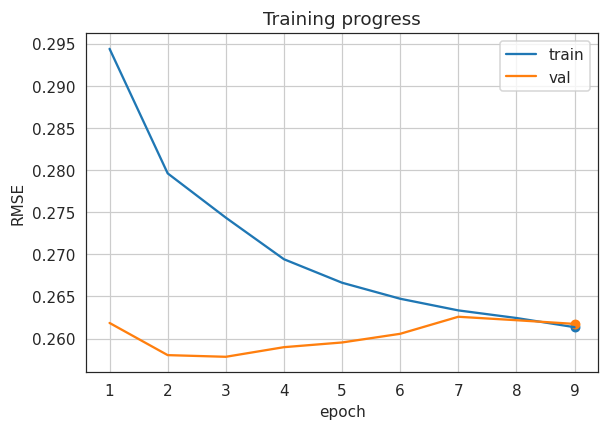

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.29439 MAE=0.24335 R2=-0.02902 | Acc=0.69324 Prec=0.35638 Rec=0.14569 F1=0.20683 AUROC=0.58867 | T_ACC=0.33227 T_P=0.33232 T_R=0.33227 T_F1=0.14719 T_AUC=0.49811
VALID→ RMSE=0.26185 MAE=0.19303 R2=0.16382 | Acc=0.73052 Prec=0.78018 Rec=0.07195 F1=0.13175 AUROC=0.70621 | T_ACC=0.33335 T_P=0.33340 T_R=0.33335 T_F1=0.00016 T_AUC=0.53697


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.27960 MAE=0.23060 R2=0.07176 | Acc=0.71966 Prec=0.46586 Rec=0.14448 F1=0.22056 AUROC=0.61862 | T_ACC=0.33423 T_P=0.33388 T_R=0.33423 T_F1=0.14806 T_AUC=0.50095
VALID→ RMSE=0.25803 MAE=0.19694 R2=0.18803 | Acc=0.74262 Prec=0.69668 Rec=0.16691 F1=0.26930 AUROC=0.72957 | T_ACC=0.33334 T_P=0.33340 T_R=0.33334 T_F1=0.00016 T_AUC=0.53846


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.27435 MAE=0.22738 R2=0.10633 | Acc=0.73423 Prec=0.54381 Rec=0.19783 F1=0.29012 AUROC=0.65675 | T_ACC=0.33693 T_P=0.33588 T_R=0.33693 T_F1=0.15179 T_AUC=0.50469
VALID→ RMSE=0.25783 MAE=0.20202 R2=0.18928 | Acc=0.74828 Prec=0.67970 Rec=0.21592 F1=0.32773 AUROC=0.74191 | T_ACC=0.34080 T_P=0.33341 T_R=0.34080 T_F1=0.00025 T_AUC=0.54418


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.26941 MAE=0.22237 R2=0.13819 | Acc=0.74611 Prec=0.59991 Rec=0.22563 F1=0.32793 AUROC=0.69028 | T_ACC=0.33744 T_P=0.33722 T_R=0.33744 T_F1=0.15901 T_AUC=0.50762
VALID→ RMSE=0.25897 MAE=0.20509 R2=0.18209 | Acc=0.75290 Prec=0.66124 Rec=0.26747 F1=0.38088 AUROC=0.74744 | T_ACC=0.35919 T_P=0.33342 T_R=0.35919 T_F1=0.00102 T_AUC=0.54735


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.26662 MAE=0.21973 R2=0.15595 | Acc=0.75266 Prec=0.62017 Rec=0.25549 F1=0.36189 AUROC=0.71287 | T_ACC=0.34091 T_P=0.33945 T_R=0.34091 T_F1=0.17090 T_AUC=0.51278
VALID→ RMSE=0.25953 MAE=0.20861 R2=0.17855 | Acc=0.75430 Prec=0.65229 Rec=0.28991 F1=0.40141 AUROC=0.74772 | T_ACC=0.35747 T_P=0.33343 T_R=0.35747 T_F1=0.00235 T_AUC=0.53961


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.26472 MAE=0.21938 R2=0.16794 | Acc=0.75608 Prec=0.62148 Rec=0.28512 F1=0.39091 AUROC=0.72584 | T_ACC=0.34171 T_P=0.33989 T_R=0.34171 T_F1=0.17797 T_AUC=0.51428
VALID→ RMSE=0.26056 MAE=0.21161 R2=0.17203 | Acc=0.75496 Prec=0.64896 Rec=0.29993 F1=0.41025 AUROC=0.74510 | T_ACC=0.34728 T_P=0.33344 T_R=0.34728 T_F1=0.00160 T_AUC=0.51358


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.26334 MAE=0.21840 R2=0.17662 | Acc=0.75827 Prec=0.62523 Rec=0.29820 F1=0.40381 AUROC=0.73529 | T_ACC=0.34237 T_P=0.34011 T_R=0.34237 T_F1=0.18017 T_AUC=0.51403
VALID→ RMSE=0.26258 MAE=0.21615 R2=0.15912 | Acc=0.75494 Prec=0.63585 Rec=0.32203 F1=0.42753 AUROC=0.74256 | T_ACC=0.37455 T_P=0.33345 T_R=0.37455 T_F1=0.00211 T_AUC=0.50108


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.26244 MAE=0.21799 R2=0.18225 | Acc=0.75950 Prec=0.62646 Rec=0.30695 F1=0.41202 AUROC=0.74177 | T_ACC=0.34376 T_P=0.34024 T_R=0.34376 T_F1=0.18396 T_AUC=0.51384
VALID→ RMSE=0.26217 MAE=0.21543 R2=0.16174 | Acc=0.75536 Prec=0.63595 Rec=0.32528 F1=0.43041 AUROC=0.74239 | T_ACC=0.37813 T_P=0.33345 T_R=0.37813 T_F1=0.00916 T_AUC=0.50630


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.26134 MAE=0.21719 R2=0.18903 | Acc=0.76055 Prec=0.62836 Rec=0.31269 F1=0.41758 AUROC=0.74576 | T_ACC=0.34428 T_P=0.34094 T_R=0.34428 T_F1=0.19040 T_AUC=0.51600
VALID→ RMSE=0.26174 MAE=0.21612 R2=0.16454 | Acc=0.75522 Prec=0.62124 Rec=0.35511 F1=0.45191 AUROC=0.74421 | T_ACC=0.37600 T_P=0.33339 T_R=0.37600 T_F1=0.02226 T_AUC=0.51288


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 10
✅ Final best model saved: AAPL_0.25783_fin.pth


[I 2025-10-02 00:00:07,028] Trial 2 finished with value: 0.2578302025794983 and parameters: {'look_back': 75, 'SHORT_UNITS': 128, 'LONG_UNITS': 192, 'DROPOUT_SHORT': 0.2138123365877704, 'DROPOUT_LONG': 0.2586797223655801, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.13270598376515821, 'CONV_K': 5, 'CONV_DILATION': 2, 'SMOOTH_K': 6, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 0.0001587933249848152, 'ETA_MIN': 4.195176953253666e-06, 'WEIGHT_DECAY': 0.0017629827100702265, 'CLIPNORM': 0.670264290450731, 'CLS_LOSS_WEIGHT': 0.02452673594530767, 'SMOOTH_ALPHA': 0.00018133445069145598, 'SMOOTH_BETA': 10.75475966440094, 'SMOOTH_DELTA': 0.0010569592782796217, 'DIFF1_WEIGHT': 1.5442304499620758, 'DIFF2_WEIGHT': 0.3248728980504813}. Best is trial 1 with value: 0.2518954575061798.



▶ Trial 3 hyperparams:
{'look_back': 60, 'SHORT_UNITS': 96, 'LONG_UNITS': 256, 'DROPOUT_SHORT': 0.3257023731712583, 'DROPOUT_LONG': 0.38382939727261756, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.17958739973199486, 'CONV_K': 5, 'CONV_DILATION': 2, 'SMOOTH_K': 4, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 0.00023113491450419034, 'ETA_MIN': 2.993095783358027e-06, 'WEIGHT_DECAY': 0.0044028500411970335, 'CLIPNORM': 1.4598304733305443, 'CLS_LOSS_WEIGHT': 0.035724936765176046, 'SMOOTH_ALPHA': 0.000462560416705785, 'SMOOTH_BETA': 11.562018569269227, 'SMOOTH_DELTA': 0.0038701241265974387, 'DIFF1_WEIGHT': 1.0820571311681477, 'DIFF2_WEIGHT': 0.30438010634196183}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

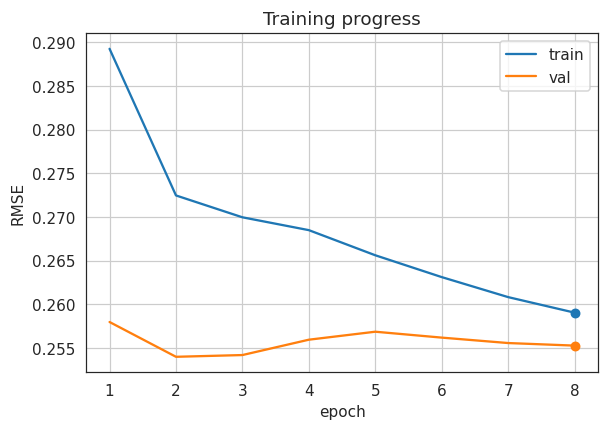

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.28926 MAE=0.23526 R2=0.00830 | Acc=0.70381 Prec=0.37612 Rec=0.10730 F1=0.16697 AUROC=0.59113 | T_ACC=0.32020 T_P=0.32480 T_R=0.32020 T_F1=0.21006 T_AUC=0.47574
VALID→ RMSE=0.25796 MAE=0.19339 R2=0.19220 | Acc=0.73469 Prec=0.72273 Rec=0.12418 F1=0.21195 AUROC=0.72428 | T_ACC=0.35622 T_P=0.33341 T_R=0.35622 T_F1=0.01026 T_AUC=0.40192


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.27246 MAE=0.22225 R2=0.12017 | Acc=0.73393 Prec=0.55095 Rec=0.20656 F1=0.30046 AUROC=0.67043 | T_ACC=0.32402 T_P=0.32478 T_R=0.32402 T_F1=0.17392 T_AUC=0.47767
VALID→ RMSE=0.25397 MAE=0.19521 R2=0.21697 | Acc=0.74822 Prec=0.68331 Rec=0.23040 F1=0.34461 AUROC=0.74294 | T_ACC=0.30635 T_P=0.33337 T_R=0.30635 T_F1=0.00017 T_AUC=0.39410


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.26996 MAE=0.22307 R2=0.13626 | Acc=0.74834 Prec=0.59654 Rec=0.27897 F1=0.38016 AUROC=0.71258 | T_ACC=0.32577 T_P=0.32470 T_R=0.32577 T_F1=0.15152 T_AUC=0.47925
VALID→ RMSE=0.25417 MAE=0.20517 R2=0.21574 | Acc=0.75489 Prec=0.65564 Rec=0.30928 F1=0.42029 AUROC=0.74967 | T_ACC=0.33334 T_P=0.33337 T_R=0.33334 T_F1=0.00008 T_AUC=0.41709


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.26848 MAE=0.22248 R2=0.14565 | Acc=0.75257 Prec=0.59785 Rec=0.32255 F1=0.41903 AUROC=0.72896 | T_ACC=0.32635 T_P=0.32407 T_R=0.32635 T_F1=0.14092 T_AUC=0.48036
VALID→ RMSE=0.25593 MAE=0.20682 R2=0.20484 | Acc=0.75520 Prec=0.64574 Rec=0.32770 F1=0.43477 AUROC=0.74994 | T_ACC=0.33334 T_P=0.33337 T_R=0.33334 T_F1=0.00008 T_AUC=0.43747


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.26561 MAE=0.22037 R2=0.16387 | Acc=0.75474 Prec=0.60224 Rec=0.33403 F1=0.42971 AUROC=0.73800 | T_ACC=0.32852 T_P=0.32420 T_R=0.32852 T_F1=0.13404 T_AUC=0.48156
VALID→ RMSE=0.25685 MAE=0.20825 R2=0.19915 | Acc=0.75492 Prec=0.63987 Rec=0.33610 F1=0.44071 AUROC=0.75061 | T_ACC=0.33334 T_P=0.33337 T_R=0.33334 T_F1=0.00008 T_AUC=0.44870


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.26311 MAE=0.21816 R2=0.17954 | Acc=0.75709 Prec=0.60910 Rec=0.34030 F1=0.43665 AUROC=0.74370 | T_ACC=0.32833 T_P=0.32340 T_R=0.32833 T_F1=0.12963 T_AUC=0.48121
VALID→ RMSE=0.25617 MAE=0.20673 R2=0.20336 | Acc=0.75519 Prec=0.65234 Rec=0.31662 F1=0.42632 AUROC=0.75186 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.45032


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.26081 MAE=0.21610 R2=0.19378 | Acc=0.75965 Prec=0.61726 Rec=0.34521 F1=0.44279 AUROC=0.75047 | T_ACC=0.32852 T_P=0.32341 T_R=0.32852 T_F1=0.12630 T_AUC=0.48201
VALID→ RMSE=0.25555 MAE=0.20560 R2=0.20722 | Acc=0.75569 Prec=0.65179 Rec=0.32124 F1=0.43037 AUROC=0.75499 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.45480


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.25903 MAE=0.21426 R2=0.20475 | Acc=0.76163 Prec=0.62298 Rec=0.35033 F1=0.44846 AUROC=0.75597 | T_ACC=0.32908 T_P=0.32364 T_R=0.32908 T_F1=0.12435 T_AUC=0.48278
VALID→ RMSE=0.25526 MAE=0.20523 R2=0.20905 | Acc=0.75522 Prec=0.64914 Rec=0.32206 F1=0.43052 AUROC=0.75631 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.46023


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 9
✅ Final best model saved: AAPL_0.25397_fin.pth


[I 2025-10-02 00:11:53,932] Trial 3 finished with value: 0.25397413969039917 and parameters: {'look_back': 60, 'SHORT_UNITS': 96, 'LONG_UNITS': 256, 'DROPOUT_SHORT': 0.3257023731712583, 'DROPOUT_LONG': 0.38382939727261756, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.17958739973199486, 'CONV_K': 5, 'CONV_DILATION': 2, 'SMOOTH_K': 4, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 0.00023113491450419034, 'ETA_MIN': 2.993095783358027e-06, 'WEIGHT_DECAY': 0.0044028500411970335, 'CLIPNORM': 1.4598304733305443, 'CLS_LOSS_WEIGHT': 0.035724936765176046, 'SMOOTH_ALPHA': 0.000462560416705785, 'SMOOTH_BETA': 11.562018569269227, 'SMOOTH_DELTA': 0.0038701241265974387, 'DIFF1_WEIGHT': 1.0820571311681477, 'DIFF2_WEIGHT': 0.30438010634196183}. Best is trial 1 with value: 0.2518954575061798.



▶ Trial 4 hyperparams:
{'look_back': 75, 'SHORT_UNITS': 128, 'LONG_UNITS': 192, 'DROPOUT_SHORT': 0.19187718497441025, 'DROPOUT_LONG': 0.24768505681672984, 'ATT_HEADS': 16, 'ATT_DROPOUT': 0.2858555554331792, 'CONV_K': 2, 'CONV_DILATION': 2, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 2, 'INITIAL_LR': 0.00019847862293690655, 'ETA_MIN': 8.257464009586908e-07, 'WEIGHT_DECAY': 0.004482735194249301, 'CLIPNORM': 4.161700652647291, 'CLS_LOSS_WEIGHT': 0.08870912017705417, 'SMOOTH_ALPHA': 0.0010129461328346064, 'SMOOTH_BETA': 13.932608549786218, 'SMOOTH_DELTA': 0.0019539037088227096, 'DIFF1_WEIGHT': 1.6041579765083753, 'DIFF2_WEIGHT': 0.1740100096330131}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

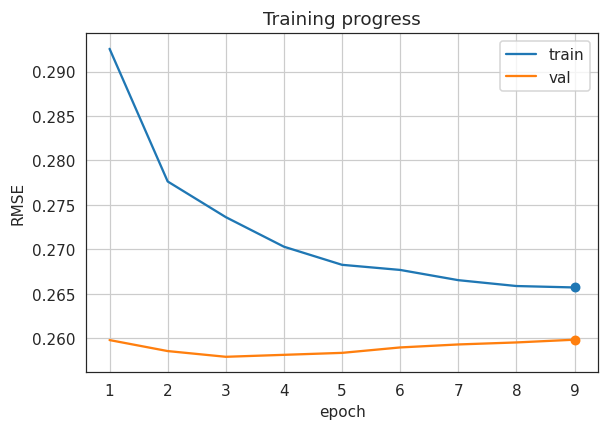

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.29256 MAE=0.24294 R2=-0.01626 | Acc=0.71171 Prec=0.38871 Rec=0.08758 F1=0.14295 AUROC=0.60838 | T_ACC=0.29855 T_P=0.31594 T_R=0.29855 T_F1=0.27482 T_AUC=0.44265
VALID→ RMSE=0.25979 MAE=0.20068 R2=0.17691 | Acc=0.71663 Prec=0.58701 Rec=0.00936 F1=0.01843 AUROC=0.70667 | T_ACC=0.22095 T_P=0.33322 T_R=0.22095 T_F1=0.22242 T_AUC=0.24483


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.27763 MAE=0.22882 R2=0.08479 | Acc=0.73647 Prec=0.55782 Rec=0.19315 F1=0.28695 AUROC=0.68926 | T_ACC=0.30036 T_P=0.31360 T_R=0.30036 T_F1=0.23714 T_AUC=0.44429
VALID→ RMSE=0.25855 MAE=0.19862 R2=0.18473 | Acc=0.74016 Prec=0.66981 Rec=0.16879 F1=0.26964 AUROC=0.73665 | T_ACC=0.20848 T_P=0.33320 T_R=0.20848 T_F1=0.18435 T_AUC=0.21815


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.27362 MAE=0.22607 R2=0.11106 | Acc=0.74842 Prec=0.59803 Rec=0.25490 F1=0.35745 AUROC=0.71768 | T_ACC=0.29545 T_P=0.30986 T_R=0.29545 T_F1=0.21886 T_AUC=0.43507
VALID→ RMSE=0.25791 MAE=0.19963 R2=0.18879 | Acc=0.74824 Prec=0.67396 Rec=0.22087 F1=0.33271 AUROC=0.74482 | T_ACC=0.16582 T_P=0.33313 T_R=0.16582 T_F1=0.13513 T_AUC=0.16711


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.27029 MAE=0.22449 R2=0.13254 | Acc=0.75164 Prec=0.59855 Rec=0.28945 F1=0.39021 AUROC=0.72650 | T_ACC=0.29384 T_P=0.30688 T_R=0.29384 T_F1=0.19996 T_AUC=0.43047
VALID→ RMSE=0.25813 MAE=0.19985 R2=0.18740 | Acc=0.75062 Prec=0.68612 Rec=0.22559 F1=0.33954 AUROC=0.75037 | T_ACC=0.14380 T_P=0.33309 T_R=0.14380 T_F1=0.11806 T_AUC=0.13525


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.26826 MAE=0.22410 R2=0.14557 | Acc=0.75346 Prec=0.60149 Rec=0.30204 F1=0.40214 AUROC=0.73240 | T_ACC=0.29159 T_P=0.30433 T_R=0.29159 T_F1=0.18919 T_AUC=0.42448
VALID→ RMSE=0.25835 MAE=0.20393 R2=0.18600 | Acc=0.75130 Prec=0.69121 Rec=0.22554 F1=0.34010 AUROC=0.75130 | T_ACC=0.13346 T_P=0.33303 T_R=0.13346 T_F1=0.09055 T_AUC=0.12016


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.26768 MAE=0.22444 R2=0.14924 | Acc=0.75531 Prec=0.60295 Rec=0.31820 F1=0.41657 AUROC=0.73831 | T_ACC=0.29282 T_P=0.30256 T_R=0.29282 T_F1=0.17394 T_AUC=0.42510
VALID→ RMSE=0.25896 MAE=0.20542 R2=0.18215 | Acc=0.75202 Prec=0.68278 Rec=0.23780 F1=0.35274 AUROC=0.75129 | T_ACC=0.14327 T_P=0.33299 T_R=0.14327 T_F1=0.07801 T_AUC=0.11931


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.26653 MAE=0.22356 R2=0.15654 | Acc=0.75631 Prec=0.60594 Rec=0.32119 F1=0.41984 AUROC=0.74311 | T_ACC=0.29419 T_P=0.30144 T_R=0.29419 T_F1=0.16373 T_AUC=0.42519
VALID→ RMSE=0.25930 MAE=0.20671 R2=0.18003 | Acc=0.75173 Prec=0.67045 Rec=0.24843 F1=0.36253 AUROC=0.75215 | T_ACC=0.14307 T_P=0.33293 T_R=0.14307 T_F1=0.06331 T_AUC=0.12128


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.26587 MAE=0.22322 R2=0.16070 | Acc=0.75814 Prec=0.60937 Rec=0.33150 F1=0.42940 AUROC=0.74775 | T_ACC=0.29704 T_P=0.30068 T_R=0.29704 T_F1=0.15286 T_AUC=0.42836
VALID→ RMSE=0.25952 MAE=0.20820 R2=0.17860 | Acc=0.75117 Prec=0.65502 Rec=0.26270 F1=0.37501 AUROC=0.75337 | T_ACC=0.15471 T_P=0.33288 T_R=0.15471 T_F1=0.05267 T_AUC=0.12373


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.26571 MAE=0.22341 R2=0.16172 | Acc=0.75943 Prec=0.60931 Rec=0.34469 F1=0.44030 AUROC=0.75227 | T_ACC=0.30054 T_P=0.30206 T_R=0.30054 T_F1=0.14631 T_AUC=0.43333
VALID→ RMSE=0.25983 MAE=0.20925 R2=0.17664 | Acc=0.75019 Prec=0.64023 Rec=0.27595 F1=0.38567 AUROC=0.75328 | T_ACC=0.14411 T_P=0.33284 T_R=0.14411 T_F1=0.04996 T_AUC=0.12929


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 10
✅ Final best model saved: AAPL_0.25791_fin.pth


[I 2025-10-02 00:28:31,204] Trial 4 finished with value: 0.25790882110595703 and parameters: {'look_back': 75, 'SHORT_UNITS': 128, 'LONG_UNITS': 192, 'DROPOUT_SHORT': 0.19187718497441025, 'DROPOUT_LONG': 0.24768505681672984, 'ATT_HEADS': 16, 'ATT_DROPOUT': 0.2858555554331792, 'CONV_K': 2, 'CONV_DILATION': 2, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 2, 'INITIAL_LR': 0.00019847862293690655, 'ETA_MIN': 8.257464009586908e-07, 'WEIGHT_DECAY': 0.004482735194249301, 'CLIPNORM': 4.161700652647291, 'CLS_LOSS_WEIGHT': 0.08870912017705417, 'SMOOTH_ALPHA': 0.0010129461328346064, 'SMOOTH_BETA': 13.932608549786218, 'SMOOTH_DELTA': 0.0019539037088227096, 'DIFF1_WEIGHT': 1.6041579765083753, 'DIFF2_WEIGHT': 0.1740100096330131}. Best is trial 1 with value: 0.2518954575061798.



▶ Trial 5 hyperparams:
{'look_back': 75, 'SHORT_UNITS': 96, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.10687051893718547, 'DROPOUT_LONG': 0.3640396249185537, 'ATT_HEADS': 16, 'ATT_DROPOUT': 0.21947759367683603, 'CONV_K': 5, 'CONV_DILATION': 1, 'SMOOTH_K': 7, 'SMOOTH_DILATION': 2, 'INITIAL_LR': 5.4165584489516154e-05, 'ETA_MIN': 1.3516408290706766e-07, 'WEIGHT_DECAY': 0.0017598169625142655, 'CLIPNORM': 2.1493946660130065, 'CLS_LOSS_WEIGHT': 0.015874864529761015, 'SMOOTH_ALPHA': 0.008712007426486562, 'SMOOTH_BETA': 22.566894285622475, 'SMOOTH_DELTA': 0.0025231298638107294, 'DIFF1_WEIGHT': 1.918593270000317, 'DIFF2_WEIGHT': 0.39956363419626834}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

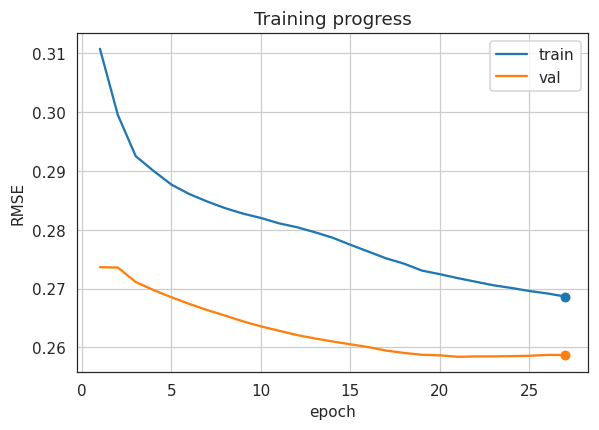

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.31074 MAE=0.26011 R2=-0.14651 | Acc=0.63134 Prec=0.33263 Rec=0.34076 F1=0.33665 AUROC=0.56814 | T_ACC=0.33077 T_P=0.33741 T_R=0.33077 T_F1=0.12692 T_AUC=0.50267
VALID→ RMSE=0.27364 MAE=0.20526 R2=0.08682 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.53198 | T_ACC=0.28909 T_P=0.33344 T_R=0.28909 T_F1=0.00022 T_AUC=0.52157


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.29952 MAE=0.25082 R2=-0.06520 | Acc=0.72261 Prec=0.35752 Rec=0.01310 F1=0.02528 AUROC=0.52700 | T_ACC=0.33431 T_P=0.34152 T_R=0.33431 T_F1=0.13133 T_AUC=0.51049
VALID→ RMSE=0.27358 MAE=0.20129 R2=0.08721 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.59406 | T_ACC=0.31852 T_P=0.33346 T_R=0.31852 T_F1=0.00031 T_AUC=0.51930


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.29251 MAE=0.24026 R2=-0.01590 | Acc=0.72349 Prec=0.41021 Rec=0.01652 F1=0.03176 AUROC=0.55363 | T_ACC=0.33415 T_P=0.34090 T_R=0.33415 T_F1=0.13936 T_AUC=0.51021
VALID→ RMSE=0.27113 MAE=0.20145 R2=0.10350 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.63671 | T_ACC=0.31864 T_P=0.33347 T_R=0.31864 T_F1=0.00057 T_AUC=0.51841


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.28999 MAE=0.23806 R2=0.00151 | Acc=0.72413 Prec=0.44521 Rec=0.01987 F1=0.03805 AUROC=0.57079 | T_ACC=0.33430 T_P=0.33979 T_R=0.33430 T_F1=0.14853 T_AUC=0.50844
VALID→ RMSE=0.26975 MAE=0.20120 R2=0.11260 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.66481 | T_ACC=0.31913 T_P=0.33349 T_R=0.31913 T_F1=0.00157 T_AUC=0.51764


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.28767 MAE=0.23533 R2=0.01745 | Acc=0.72514 Prec=0.48856 Rec=0.02634 F1=0.04998 AUROC=0.59021 | T_ACC=0.33351 T_P=0.33869 T_R=0.33351 T_F1=0.15732 T_AUC=0.50636
VALID→ RMSE=0.26852 MAE=0.20112 R2=0.12065 | Acc=0.71584 Prec=1.00000 Rec=0.00001 F1=0.00002 AUROC=0.68617 | T_ACC=0.30307 T_P=0.33348 T_R=0.30307 T_F1=0.00387 T_AUC=0.51573


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.28607 MAE=0.23388 R2=0.02836 | Acc=0.72670 Prec=0.53336 Rec=0.03570 F1=0.06693 AUROC=0.60971 | T_ACC=0.33247 T_P=0.33762 T_R=0.33247 T_F1=0.16452 T_AUC=0.50299
VALID→ RMSE=0.26740 MAE=0.20097 R2=0.12799 | Acc=0.71596 Prec=0.97674 Rec=0.00042 F1=0.00084 AUROC=0.70196 | T_ACC=0.31483 T_P=0.33349 T_R=0.31483 T_F1=0.00774 T_AUC=0.51157


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.28480 MAE=0.23283 R2=0.03695 | Acc=0.72905 Prec=0.57216 Rec=0.05156 F1=0.09460 AUROC=0.62871 | T_ACC=0.33044 T_P=0.33543 T_R=0.33044 T_F1=0.16959 T_AUC=0.49907
VALID→ RMSE=0.26635 MAE=0.20087 R2=0.13481 | Acc=0.71668 Prec=0.92711 Rec=0.00320 F1=0.00637 AUROC=0.71385 | T_ACC=0.31037 T_P=0.33335 T_R=0.31037 T_F1=0.01347 T_AUC=0.50420


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.28367 MAE=0.23219 R2=0.04456 | Acc=0.73215 Prec=0.59898 Rec=0.07352 F1=0.13097 AUROC=0.64695 | T_ACC=0.32844 T_P=0.33348 T_R=0.32844 T_F1=0.17290 T_AUC=0.49454
VALID→ RMSE=0.26542 MAE=0.20083 R2=0.14088 | Acc=0.71927 Prec=0.89953 Rec=0.01360 F1=0.02679 AUROC=0.72301 | T_ACC=0.26806 T_P=0.33332 T_R=0.26806 T_F1=0.02015 T_AUC=0.49018


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.28274 MAE=0.23191 R2=0.05080 | Acc=0.73576 Prec=0.61111 Rec=0.10301 F1=0.17630 AUROC=0.66304 | T_ACC=0.32709 T_P=0.33171 T_R=0.32709 T_F1=0.17489 T_AUC=0.49002
VALID→ RMSE=0.26444 MAE=0.20099 R2=0.14718 | Acc=0.72471 Prec=0.87041 Rec=0.03667 F1=0.07038 AUROC=0.72980 | T_ACC=0.23647 T_P=0.33333 T_R=0.23647 T_F1=0.02840 T_AUC=0.47206


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.28200 MAE=0.23216 R2=0.05576 | Acc=0.73940 Prec=0.61246 Rec=0.13815 F1=0.22544 AUROC=0.67655 | T_ACC=0.32483 T_P=0.32979 T_R=0.32483 T_F1=0.17718 T_AUC=0.48404
VALID→ RMSE=0.26358 MAE=0.20108 R2=0.15270 | Acc=0.73181 Prec=0.83441 Rec=0.07013 F1=0.12938 AUROC=0.73501 | T_ACC=0.23315 T_P=0.33334 T_R=0.23315 T_F1=0.03723 T_AUC=0.44837


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.28110 MAE=0.23204 R2=0.06178 | Acc=0.74281 Prec=0.61078 Rec=0.17403 F1=0.27087 AUROC=0.68830 | T_ACC=0.32039 T_P=0.32633 T_R=0.32039 T_F1=0.17723 T_AUC=0.47662
VALID→ RMSE=0.26285 MAE=0.20142 R2=0.15741 | Acc=0.73841 Prec=0.79554 Rec=0.10689 F1=0.18846 AUROC=0.73865 | T_ACC=0.23037 T_P=0.33333 T_R=0.23037 T_F1=0.04678 T_AUC=0.42173


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.28044 MAE=0.23245 R2=0.06619 | Acc=0.74597 Prec=0.60677 Rec=0.21207 F1=0.31430 AUROC=0.69817 | T_ACC=0.31657 T_P=0.32335 T_R=0.31657 T_F1=0.17937 T_AUC=0.46973
VALID→ RMSE=0.26213 MAE=0.20186 R2=0.16204 | Acc=0.74385 Prec=0.76298 Rec=0.14301 F1=0.24087 AUROC=0.74155 | T_ACC=0.24793 T_P=0.33329 T_R=0.24793 T_F1=0.05860 T_AUC=0.39549


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.27960 MAE=0.23267 R2=0.07179 | Acc=0.74804 Prec=0.60029 Rec=0.24596 F1=0.34895 AUROC=0.70622 | T_ACC=0.31398 T_P=0.32118 T_R=0.31398 T_F1=0.18248 T_AUC=0.46321
VALID→ RMSE=0.26155 MAE=0.20247 R2=0.16573 | Acc=0.74792 Prec=0.73304 Rec=0.17754 F1=0.28585 AUROC=0.74387 | T_ACC=0.24645 T_P=0.33329 T_R=0.24645 T_F1=0.07091 T_AUC=0.37167


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.27866 MAE=0.23272 R2=0.07800 | Acc=0.74941 Prec=0.59408 Rec=0.27521 F1=0.37617 AUROC=0.71323 | T_ACC=0.30847 T_P=0.31718 T_R=0.30847 T_F1=0.18417 T_AUC=0.45464
VALID→ RMSE=0.26102 MAE=0.20317 R2=0.16908 | Acc=0.75075 Prec=0.71019 Rec=0.20756 F1=0.32123 AUROC=0.74587 | T_ACC=0.22740 T_P=0.33325 T_R=0.22740 T_F1=0.08336 T_AUC=0.35310


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.27746 MAE=0.23243 R2=0.08596 | Acc=0.75092 Prec=0.59151 Rec=0.29960 F1=0.39774 AUROC=0.71915 | T_ACC=0.30515 T_P=0.31441 T_R=0.30515 T_F1=0.18628 T_AUC=0.44772
VALID→ RMSE=0.26055 MAE=0.20389 R2=0.17211 | Acc=0.75272 Prec=0.69384 Rec=0.23228 F1=0.34805 AUROC=0.74762 | T_ACC=0.22757 T_P=0.33325 T_R=0.22757 T_F1=0.09590 T_AUC=0.34077


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.27630 MAE=0.23226 R2=0.09356 | Acc=0.75160 Prec=0.58822 Rec=0.31726 F1=0.41220 AUROC=0.72415 | T_ACC=0.30086 T_P=0.31223 T_R=0.30086 T_F1=0.18908 T_AUC=0.43982
VALID→ RMSE=0.26007 MAE=0.20453 R2=0.17516 | Acc=0.75426 Prec=0.68067 Rec=0.25470 F1=0.37069 AUROC=0.74917 | T_ACC=0.21793 T_P=0.33327 T_R=0.21793 T_F1=0.10791 T_AUC=0.33346


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.27515 MAE=0.23189 R2=0.10112 | Acc=0.75309 Prec=0.59003 Rec=0.32956 F1=0.42291 AUROC=0.72844 | T_ACC=0.29811 T_P=0.30993 T_R=0.29811 T_F1=0.19095 T_AUC=0.43311
VALID→ RMSE=0.25947 MAE=0.20499 R2=0.17891 | Acc=0.75516 Prec=0.67183 Rec=0.27052 F1=0.38572 AUROC=0.75061 | T_ACC=0.25427 T_P=0.33331 T_R=0.25427 T_F1=0.11755 T_AUC=0.33052


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.27424 MAE=0.23167 R2=0.10701 | Acc=0.75337 Prec=0.58915 Rec=0.33572 F1=0.42771 AUROC=0.73130 | T_ACC=0.29530 T_P=0.30814 T_R=0.29530 T_F1=0.19286 T_AUC=0.42850
VALID→ RMSE=0.25907 MAE=0.20545 R2=0.18144 | Acc=0.75556 Prec=0.66804 Rec=0.27786 F1=0.39247 AUROC=0.75173 | T_ACC=0.27107 T_P=0.33335 T_R=0.27107 T_F1=0.12695 T_AUC=0.32816


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.27307 MAE=0.23086 R2=0.11466 | Acc=0.75462 Prec=0.59280 Rec=0.33903 F1=0.43136 AUROC=0.73365 | T_ACC=0.29334 T_P=0.30723 T_R=0.29334 T_F1=0.19605 T_AUC=0.42445
VALID→ RMSE=0.25876 MAE=0.20609 R2=0.18342 | Acc=0.75624 Prec=0.66328 Rec=0.28880 F1=0.40239 AUROC=0.75267 | T_ACC=0.28012 T_P=0.33335 T_R=0.28012 T_F1=0.13755 T_AUC=0.32722


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.27246 MAE=0.23079 R2=0.11860 | Acc=0.75541 Prec=0.59459 Rec=0.34267 F1=0.43477 AUROC=0.73634 | T_ACC=0.29126 T_P=0.30618 T_R=0.29126 T_F1=0.19886 T_AUC=0.42068
VALID→ RMSE=0.25867 MAE=0.20686 R2=0.18399 | Acc=0.75646 Prec=0.65900 Rec=0.29628 F1=0.40878 AUROC=0.75341 | T_ACC=0.27740 T_P=0.33333 T_R=0.27740 T_F1=0.14532 T_AUC=0.32586


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.27179 MAE=0.23045 R2=0.12293 | Acc=0.75630 Prec=0.59704 Rec=0.34537 F1=0.43760 AUROC=0.73889 | T_ACC=0.29018 T_P=0.30526 T_R=0.29018 T_F1=0.20105 T_AUC=0.41789
VALID→ RMSE=0.25842 MAE=0.20716 R2=0.18559 | Acc=0.75681 Prec=0.65337 Rec=0.30712 F1=0.41783 AUROC=0.75397 | T_ACC=0.28408 T_P=0.33337 T_R=0.28408 T_F1=0.15343 T_AUC=0.32544


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.27118 MAE=0.23013 R2=0.12687 | Acc=0.75675 Prec=0.59780 Rec=0.34815 F1=0.44003 AUROC=0.74048 | T_ACC=0.28916 T_P=0.30487 T_R=0.28916 T_F1=0.20457 T_AUC=0.41512
VALID→ RMSE=0.25848 MAE=0.20785 R2=0.18520 | Acc=0.75693 Prec=0.65113 Rec=0.31152 F1=0.42142 AUROC=0.75444 | T_ACC=0.26279 T_P=0.33331 T_R=0.26279 T_F1=0.16186 T_AUC=0.32637


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.27057 MAE=0.22971 R2=0.13079 | Acc=0.75761 Prec=0.60049 Rec=0.34973 F1=0.44202 AUROC=0.74239 | T_ACC=0.28803 T_P=0.30427 T_R=0.28803 T_F1=0.20678 T_AUC=0.41297
VALID→ RMSE=0.25849 MAE=0.20841 R2=0.18514 | Acc=0.75700 Prec=0.64755 Rec=0.31783 F1=0.42638 AUROC=0.75485 | T_ACC=0.25783 T_P=0.33332 T_R=0.25783 T_F1=0.16739 T_AUC=0.32647


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.27012 MAE=0.22951 R2=0.13367 | Acc=0.75788 Prec=0.60150 Rec=0.34977 F1=0.44232 AUROC=0.74373 | T_ACC=0.28682 T_P=0.30379 T_R=0.28682 T_F1=0.20834 T_AUC=0.41120
VALID→ RMSE=0.25853 MAE=0.20886 R2=0.18490 | Acc=0.75701 Prec=0.64485 Rec=0.32254 F1=0.43000 AUROC=0.75523 | T_ACC=0.27239 T_P=0.33335 T_R=0.27239 T_F1=0.17271 T_AUC=0.32741


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.26959 MAE=0.22911 R2=0.13703 | Acc=0.75821 Prec=0.60214 Rec=0.35150 F1=0.44389 AUROC=0.74532 | T_ACC=0.28640 T_P=0.30340 T_R=0.28640 T_F1=0.20996 T_AUC=0.41041
VALID→ RMSE=0.25859 MAE=0.20937 R2=0.18452 | Acc=0.75706 Prec=0.64123 Rec=0.32929 F1=0.43513 AUROC=0.75561 | T_ACC=0.28666 T_P=0.33338 T_R=0.28666 T_F1=0.17762 T_AUC=0.32978


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ RMSE=0.26919 MAE=0.22886 R2=0.13961 | Acc=0.75878 Prec=0.60388 Rec=0.35259 F1=0.44522 AUROC=0.74662 | T_ACC=0.28609 T_P=0.30369 T_R=0.28609 T_F1=0.21245 T_AUC=0.40922
VALID→ RMSE=0.25873 MAE=0.20989 R2=0.18359 | Acc=0.75700 Prec=0.63942 Rec=0.33214 F1=0.43719 AUROC=0.75593 | T_ACC=0.29047 T_P=0.33341 T_R=0.29047 T_F1=0.18175 T_AUC=0.33152


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ RMSE=0.26866 MAE=0.22838 R2=0.14302 | Acc=0.75958 Prec=0.60713 Rec=0.35205 F1=0.44567 AUROC=0.74794 | T_ACC=0.28436 T_P=0.30277 T_R=0.28436 T_F1=0.21279 T_AUC=0.40754
VALID→ RMSE=0.25873 MAE=0.21008 R2=0.18360 | Acc=0.75705 Prec=0.63731 Rec=0.33658 F1=0.44051 AUROC=0.75620 | T_ACC=0.29460 T_P=0.33343 T_R=0.29460 T_F1=0.18611 T_AUC=0.33355


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 28
✅ Final best model saved: AAPL_0.25842_fin.pth


[I 2025-10-02 01:06:02,534] Trial 5 finished with value: 0.25841718912124634 and parameters: {'look_back': 75, 'SHORT_UNITS': 96, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.10687051893718547, 'DROPOUT_LONG': 0.3640396249185537, 'ATT_HEADS': 16, 'ATT_DROPOUT': 0.21947759367683603, 'CONV_K': 5, 'CONV_DILATION': 1, 'SMOOTH_K': 7, 'SMOOTH_DILATION': 2, 'INITIAL_LR': 5.4165584489516154e-05, 'ETA_MIN': 1.3516408290706766e-07, 'WEIGHT_DECAY': 0.0017598169625142655, 'CLIPNORM': 2.1493946660130065, 'CLS_LOSS_WEIGHT': 0.015874864529761015, 'SMOOTH_ALPHA': 0.008712007426486562, 'SMOOTH_BETA': 22.566894285622475, 'SMOOTH_DELTA': 0.0025231298638107294, 'DIFF1_WEIGHT': 1.918593270000317, 'DIFF2_WEIGHT': 0.39956363419626834}. Best is trial 1 with value: 0.2518954575061798.



▶ Trial 6 hyperparams:
{'look_back': 75, 'SHORT_UNITS': 128, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.3986635003211907, 'DROPOUT_LONG': 0.2169442285742023, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.26299749101874736, 'CONV_K': 3, 'CONV_DILATION': 1, 'SMOOTH_K': 6, 'SMOOTH_DILATION': 2, 'INITIAL_LR': 0.0002702468212301078, 'ETA_MIN': 1.4613452020805517e-06, 'WEIGHT_DECAY': 0.00010473025509289111, 'CLIPNORM': 3.6902884590105556, 'CLS_LOSS_WEIGHT': 0.06505957749668066, 'SMOOTH_ALPHA': 0.0038284149318291868, 'SMOOTH_BETA': 21.464846371115286, 'SMOOTH_DELTA': 0.002373735611386712, 'DIFF1_WEIGHT': 1.410836175872954, 'DIFF2_WEIGHT': 0.1759681770881964}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

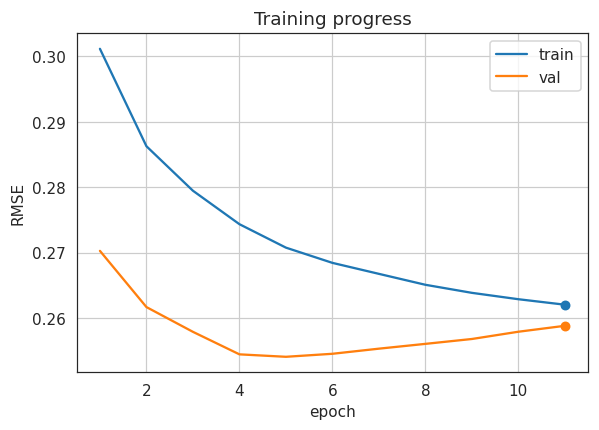

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.30115 MAE=0.24897 R2=-0.07680 | Acc=0.69094 Prec=0.31977 Rec=0.11162 F1=0.16548 AUROC=0.57213 | T_ACC=0.32501 T_P=0.34292 T_R=0.32501 T_F1=0.31086 T_AUC=0.49299
VALID→ RMSE=0.27029 MAE=0.19447 R2=0.10906 | Acc=0.72460 Prec=0.80075 Rec=0.04106 F1=0.07811 AUROC=0.71532 | T_ACC=0.39858 T_P=0.33337 T_R=0.39858 T_F1=0.31058 T_AUC=0.64698


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.28627 MAE=0.23748 R2=0.02700 | Acc=0.73012 Prec=0.52115 Rec=0.20820 F1=0.29753 AUROC=0.66656 | T_ACC=0.32345 T_P=0.35295 T_R=0.32345 T_F1=0.30087 T_AUC=0.49776
VALID→ RMSE=0.26170 MAE=0.19945 R2=0.16476 | Acc=0.75023 Prec=0.67717 Rec=0.23130 F1=0.34482 AUROC=0.73326 | T_ACC=0.40138 T_P=0.33336 T_R=0.40138 T_F1=0.30165 T_AUC=0.66280


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.27947 MAE=0.23250 R2=0.07265 | Acc=0.74533 Prec=0.57221 Rec=0.28660 F1=0.38191 AUROC=0.70277 | T_ACC=0.32259 T_P=0.35625 T_R=0.32259 T_F1=0.29597 T_AUC=0.50155
VALID→ RMSE=0.25792 MAE=0.19962 R2=0.18873 | Acc=0.75365 Prec=0.64773 Rec=0.29171 F1=0.40226 AUROC=0.73713 | T_ACC=0.41206 T_P=0.33373 T_R=0.41206 T_F1=0.28546 T_AUC=0.66576


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.27436 MAE=0.22921 R2=0.10626 | Acc=0.75454 Prec=0.60800 Rec=0.29801 F1=0.39997 AUROC=0.72446 | T_ACC=0.32235 T_P=0.35635 T_R=0.32235 T_F1=0.28379 T_AUC=0.50523
VALID→ RMSE=0.25448 MAE=0.19874 R2=0.21022 | Acc=0.75308 Prec=0.63167 Rec=0.31433 F1=0.41977 AUROC=0.73849 | T_ACC=0.39812 T_P=0.33356 T_R=0.39812 T_F1=0.26292 T_AUC=0.63711


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.27078 MAE=0.22697 R2=0.12944 | Acc=0.75734 Prec=0.61765 Rec=0.30462 F1=0.40802 AUROC=0.73687 | T_ACC=0.32108 T_P=0.35404 T_R=0.32108 T_F1=0.27482 T_AUC=0.50480
VALID→ RMSE=0.25411 MAE=0.19859 R2=0.21253 | Acc=0.75250 Prec=0.63913 Rec=0.29630 F1=0.40489 AUROC=0.73973 | T_ACC=0.32609 T_P=0.33330 T_R=0.32609 T_F1=0.25694 T_AUC=0.58755


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.26845 MAE=0.22517 R2=0.14434 | Acc=0.75915 Prec=0.62082 Rec=0.31519 F1=0.41810 AUROC=0.74463 | T_ACC=0.31864 T_P=0.35306 T_R=0.31864 T_F1=0.26783 T_AUC=0.50402
VALID→ RMSE=0.25457 MAE=0.19899 R2=0.20968 | Acc=0.75195 Prec=0.64820 Rec=0.27795 F1=0.38906 AUROC=0.74138 | T_ACC=0.29696 T_P=0.33328 T_R=0.29696 T_F1=0.23367 T_AUC=0.55217


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.26677 MAE=0.22387 R2=0.15500 | Acc=0.76040 Prec=0.62270 Rec=0.32276 F1=0.42515 AUROC=0.74981 | T_ACC=0.32284 T_P=0.35444 T_R=0.32284 T_F1=0.26254 T_AUC=0.50940
VALID→ RMSE=0.25535 MAE=0.20055 R2=0.20482 | Acc=0.75140 Prec=0.65393 Rec=0.26580 F1=0.37797 AUROC=0.74214 | T_ACC=0.32260 T_P=0.33330 T_R=0.32260 T_F1=0.23251 T_AUC=0.55931


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.26510 MAE=0.22244 R2=0.16554 | Acc=0.76163 Prec=0.62644 Rec=0.32623 F1=0.42904 AUROC=0.75320 | T_ACC=0.32411 T_P=0.35486 T_R=0.32411 T_F1=0.26163 T_AUC=0.51133
VALID→ RMSE=0.25608 MAE=0.20235 R2=0.20025 | Acc=0.75035 Prec=0.64840 Rec=0.26533 F1=0.37656 AUROC=0.74138 | T_ACC=0.32447 T_P=0.33330 T_R=0.32447 T_F1=0.21007 T_AUC=0.56457


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.26387 MAE=0.22144 R2=0.17327 | Acc=0.76285 Prec=0.62989 Rec=0.33006 F1=0.43315 AUROC=0.75687 | T_ACC=0.32836 T_P=0.35569 T_R=0.32836 T_F1=0.25581 T_AUC=0.51515
VALID→ RMSE=0.25683 MAE=0.20403 R2=0.19559 | Acc=0.74951 Prec=0.64165 Rec=0.26835 F1=0.37844 AUROC=0.74122 | T_ACC=0.32742 T_P=0.33365 T_R=0.32742 T_F1=0.20424 T_AUC=0.58564


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.26290 MAE=0.22066 R2=0.17936 | Acc=0.76402 Prec=0.63332 Rec=0.33351 F1=0.43693 AUROC=0.75954 | T_ACC=0.32728 T_P=0.35620 T_R=0.32728 T_F1=0.25128 T_AUC=0.51485
VALID→ RMSE=0.25793 MAE=0.20581 R2=0.18862 | Acc=0.74827 Prec=0.63325 Rec=0.27117 F1=0.37973 AUROC=0.74012 | T_ACC=0.31655 T_P=0.33359 T_R=0.31655 T_F1=0.18412 T_AUC=0.59850


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.26206 MAE=0.22002 R2=0.18458 | Acc=0.76533 Prec=0.63633 Rec=0.33884 F1=0.44221 AUROC=0.76254 | T_ACC=0.33143 T_P=0.35709 T_R=0.33143 T_F1=0.25178 T_AUC=0.52099
VALID→ RMSE=0.25884 MAE=0.20737 R2=0.18292 | Acc=0.74650 Prec=0.61728 Rec=0.28398 F1=0.38900 AUROC=0.73955 | T_ACC=0.35342 T_P=0.33395 T_R=0.35342 T_F1=0.19331 T_AUC=0.62042


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 12
✅ Final best model saved: AAPL_0.25411_fin.pth


[I 2025-10-02 01:21:26,543] Trial 6 finished with value: 0.2541058361530304 and parameters: {'look_back': 75, 'SHORT_UNITS': 128, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.3986635003211907, 'DROPOUT_LONG': 0.2169442285742023, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.26299749101874736, 'CONV_K': 3, 'CONV_DILATION': 1, 'SMOOTH_K': 6, 'SMOOTH_DILATION': 2, 'INITIAL_LR': 0.0002702468212301078, 'ETA_MIN': 1.4613452020805517e-06, 'WEIGHT_DECAY': 0.00010473025509289111, 'CLIPNORM': 3.6902884590105556, 'CLS_LOSS_WEIGHT': 0.06505957749668066, 'SMOOTH_ALPHA': 0.0038284149318291868, 'SMOOTH_BETA': 21.464846371115286, 'SMOOTH_DELTA': 0.002373735611386712, 'DIFF1_WEIGHT': 1.410836175872954, 'DIFF2_WEIGHT': 0.1759681770881964}. Best is trial 1 with value: 0.2518954575061798.



▶ Trial 7 hyperparams:
{'look_back': 75, 'SHORT_UNITS': 128, 'LONG_UNITS': 192, 'DROPOUT_SHORT': 0.36317146923433863, 'DROPOUT_LONG': 0.4424160532721719, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.293569647593289, 'CONV_K': 3, 'CONV_DILATION': 2, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 0.00025889918712192553, 'ETA_MIN': 4.112441861902734e-06, 'WEIGHT_DECAY': 0.0010262052593562568, 'CLIPNORM': 1.7660706470956276, 'CLS_LOSS_WEIGHT': 0.08061674037512478, 'SMOOTH_ALPHA': 0.0012190163723104681, 'SMOOTH_BETA': 23.369214672515774, 'SMOOTH_DELTA': 0.005895521714821815, 'DIFF1_WEIGHT': 1.794446023333632, 'DIFF2_WEIGHT': 0.003879253390365378}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

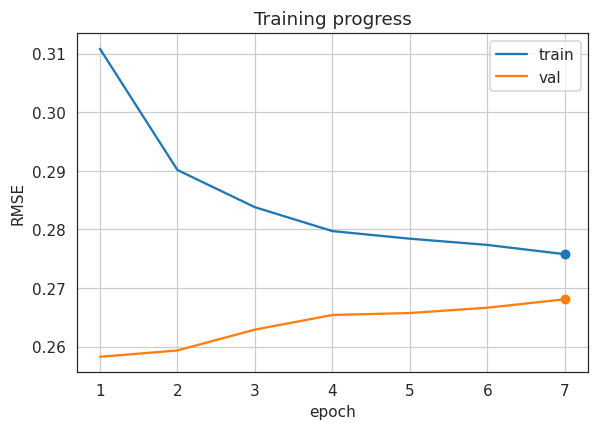

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.31082 MAE=0.26296 R2=-0.14708 | Acc=0.69696 Prec=0.36418 Rec=0.13928 F1=0.20149 AUROC=0.58011 | T_ACC=0.32918 T_P=0.33351 T_R=0.32918 T_F1=0.28368 T_AUC=0.49337
VALID→ RMSE=0.25825 MAE=0.19768 R2=0.18667 | Acc=0.72564 Prec=0.71396 Rec=0.05753 F1=0.10648 AUROC=0.70216 | T_ACC=0.34689 T_P=0.33351 T_R=0.34689 T_F1=0.07370 T_AUC=0.61214


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.29013 MAE=0.24785 R2=0.00054 | Acc=0.72976 Prec=0.51841 Rec=0.21974 F1=0.30866 AUROC=0.65322 | T_ACC=0.32771 T_P=0.33341 T_R=0.32771 T_F1=0.24833 T_AUC=0.49441
VALID→ RMSE=0.25933 MAE=0.20749 R2=0.17984 | Acc=0.73893 Prec=0.66243 Rec=0.16574 F1=0.26514 AUROC=0.72209 | T_ACC=0.31819 T_P=0.33352 T_R=0.31819 T_F1=0.01690 T_AUC=0.61809


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.28378 MAE=0.24332 R2=0.04383 | Acc=0.74517 Prec=0.57731 Rec=0.26785 F1=0.36592 AUROC=0.69208 | T_ACC=0.32962 T_P=0.33277 T_R=0.32962 T_F1=0.22603 T_AUC=0.49481
VALID→ RMSE=0.26288 MAE=0.21226 R2=0.15718 | Acc=0.73854 Prec=0.61702 Rec=0.21062 F1=0.31405 AUROC=0.71698 | T_ACC=0.31377 T_P=0.33339 T_R=0.31377 T_F1=0.00670 T_AUC=0.60476


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.27970 MAE=0.23979 R2=0.07109 | Acc=0.74996 Prec=0.58992 Rec=0.29257 F1=0.39115 AUROC=0.70945 | T_ACC=0.32752 T_P=0.33063 T_R=0.32752 T_F1=0.20983 T_AUC=0.49093
VALID→ RMSE=0.26538 MAE=0.21528 R2=0.14109 | Acc=0.73598 Prec=0.59582 Rec=0.22035 F1=0.32172 AUROC=0.71103 | T_ACC=0.35133 T_P=0.33305 T_R=0.35133 T_F1=0.00179 T_AUC=0.57474


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.27840 MAE=0.23917 R2=0.07970 | Acc=0.75252 Prec=0.59509 Rec=0.30826 F1=0.40613 AUROC=0.72118 | T_ACC=0.32656 T_P=0.32911 T_R=0.32656 T_F1=0.19586 T_AUC=0.48789
VALID→ RMSE=0.26572 MAE=0.21628 R2=0.13892 | Acc=0.73607 Prec=0.59018 Rec=0.23293 F1=0.33403 AUROC=0.70822 | T_ACC=0.34187 T_P=0.33246 T_R=0.34187 T_F1=0.00084 T_AUC=0.52993


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.27734 MAE=0.23839 R2=0.08672 | Acc=0.75413 Prec=0.60270 Rec=0.30626 F1=0.40614 AUROC=0.72875 | T_ACC=0.32466 T_P=0.32714 T_R=0.32466 T_F1=0.18534 T_AUC=0.48398
VALID→ RMSE=0.26662 MAE=0.21866 R2=0.13304 | Acc=0.73715 Prec=0.58956 Rec=0.24687 F1=0.34801 AUROC=0.70930 | T_ACC=0.33194 T_P=0.33179 T_R=0.33194 T_F1=0.00056 T_AUC=0.50135


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.27575 MAE=0.23723 R2=0.09714 | Acc=0.75661 Prec=0.61638 Rec=0.30036 F1=0.40390 AUROC=0.73630 | T_ACC=0.32465 T_P=0.32571 T_R=0.32465 T_F1=0.17611 T_AUC=0.48074
VALID→ RMSE=0.26806 MAE=0.22107 R2=0.12366 | Acc=0.73673 Prec=0.58049 Rec=0.26518 F1=0.36405 AUROC=0.70734 | T_ACC=0.35145 T_P=0.33342 T_R=0.35145 T_F1=0.00039 T_AUC=0.47400


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 8
✅ Final best model saved: AAPL_0.25825_fin.pth


[I 2025-10-02 01:33:01,459] Trial 7 finished with value: 0.2582455277442932 and parameters: {'look_back': 75, 'SHORT_UNITS': 128, 'LONG_UNITS': 192, 'DROPOUT_SHORT': 0.36317146923433863, 'DROPOUT_LONG': 0.4424160532721719, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.293569647593289, 'CONV_K': 3, 'CONV_DILATION': 2, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 0.00025889918712192553, 'ETA_MIN': 4.112441861902734e-06, 'WEIGHT_DECAY': 0.0010262052593562568, 'CLIPNORM': 1.7660706470956276, 'CLS_LOSS_WEIGHT': 0.08061674037512478, 'SMOOTH_ALPHA': 0.0012190163723104681, 'SMOOTH_BETA': 23.369214672515774, 'SMOOTH_DELTA': 0.005895521714821815, 'DIFF1_WEIGHT': 1.794446023333632, 'DIFF2_WEIGHT': 0.003879253390365378}. Best is trial 1 with value: 0.2518954575061798.



▶ Trial 8 hyperparams:
{'look_back': 90, 'SHORT_UNITS': 64, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.2838011948986265, 'DROPOUT_LONG': 0.38422453670998236, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.12190683294171857, 'CONV_K': 2, 'CONV_DILATION': 1, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 6.338448264527283e-05, 'ETA_MIN': 1.6366010485183432e-06, 'WEIGHT_DECAY': 0.00549829973662689, 'CLIPNORM': 1.4165037610793338, 'CLS_LOSS_WEIGHT': 0.08604695607619994, 'SMOOTH_ALPHA': 0.0008027859786557381, 'SMOOTH_BETA': 16.433057863823862, 'SMOOTH_DELTA': 0.009419372451803805, 'DIFF1_WEIGHT': 1.2753159838351262, 'DIFF2_WEIGHT': 0.11894814342233595}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

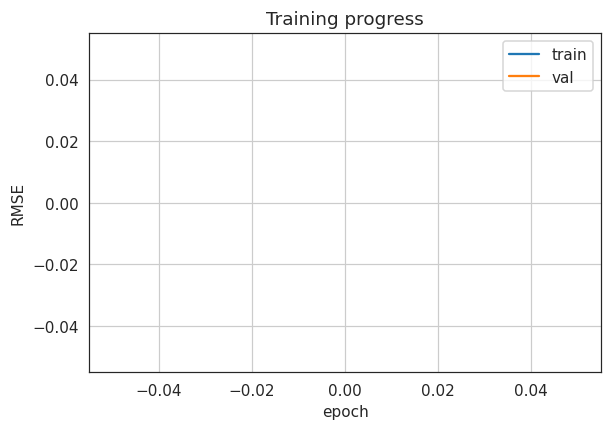

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

In [ ]:
# importlib.reload(dual_lstm) ########################

# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
